# Exploring data

Importing libraries, starting session and reading file

In [65]:
### Importing necessary libraries

#General
import time
from datetime import datetime
import pandas as pd
import numpy as np
import json
import re

#Pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, TimestampType, FloatType


#Matplot
import matplotlib.pyplot as plt
%matplotlib inline

#Wordcloud
from wordcloud import WordCloud, STOPWORDS

#VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Preprocessing data
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.correlation import plot_corr, plot_corr_grid
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

#Model and forecast
import pmdarima as pm


In [2]:
## Starting Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Greta") \
    .config("spark.sql.debug.maxToStringFields", 500) \
    .getOrCreate()

## Increasing available memory for Spark
spark.conf.set("spark.sql.legacy.setCommandRejectsSparkCoreConfs","false")
spark.conf.set("spark.executor.memory","4g")
spark.conf.set("spark.driver.memory","4g")
spark.conf.set("spark.driver.maxResultSize","4g")

In [4]:
## Read JSON file into dataframe
df = spark.read.json("hdfs://localhost:9000/ca2/Greta/greta.ndjson")

In [5]:
## Printing schema and showing
df.printSchema()
df.show()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

+------------+--------------------+--------------------+------------------+--------------------+-----------------+--------------+---------+--------------------+--------------------+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+--------------------+------------------+--------------------+-------------------+--------------------+-----------------------+-----------+-------------+-------------+---------+--------------------+---------+--------------------+------------------+---------------------+--------------+
|contributors|         coordinates|          created_at|display_text_range|            entities|extended_entities|favorite_count|favorited|           full_text|                 geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang

In [6]:
## Counting numer of rows (tweets)
df.count()

5047525

In [7]:
## Printing 1st axis columns
for col in df.columns:
    print(col)

contributors
coordinates
created_at
display_text_range
entities
extended_entities
favorite_count
favorited
full_text
geo
id
id_str
in_reply_to_screen_name
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
is_quote_status
lang
place
possibly_sensitive
quoted_status
quoted_status_id
quoted_status_id_str
quoted_status_permalink
reply_count
retrieved_utc
retweet_count
retweeted
source
truncated
user
withheld_copyright
withheld_in_countries
withheld_scope


For univariate analysis timestamp and text of tweets are extracted.

In [8]:
## Selecting only necessary columns and displaying for review
df.select("created_at","full_text").show(10, truncate=True)

+--------------------+--------------------+
|          created_at|           full_text|
+--------------------+--------------------+
|Sat Jun 09 12:07:...|@TheBear147801 @m...|
|Sat Jun 09 12:07:...|@greta @VOANews I...|
|Sat Jun 09 12:08:...|nainlab najud kog...|
|Sat Jun 09 12:10:...|   @greta What a guy|
|Sat Jun 09 12:10:...|@VelascoEber @GRE...|
|Sat Jun 09 12:11:...|Thanks @Greta__So...|
|Sat Jun 09 12:11:...|¡Buen sábado para...|
|Sat Jun 09 12:13:...|Quite sorry my mi...|
|Sat Jun 09 12:14:...|Kilaal mong magal...|
|Sat Jun 09 12:14:...|@ImmaBrox @mernan...|
+--------------------+--------------------+
only showing top 10 rows



In [9]:
## Displaying full text for additional review
df.select("created_at","full_text").show(1, truncate=False)

+------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|created_at                    |full_text                                                                                                                                                                                                                                                    |
+------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Sat Jun 09 12:07:04 +0000 2018|@TheBear147801 @markwinder8 @DavidCallender @GlassboyBob @uk_interrobang @MariaBF1 @TammyThroneber4 @JeffA9

# Cleaning data

Fixing timestamps, cleaning text, reducing data for further analysis

In [10]:
## Creating new df from selected columns
df_work = df.select("created_at","full_text")

In [11]:
## Creating function for cleaning texts
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'greta', ' ', text)
    text = re.sub(r'thunberg', ' ', text)
    text = re.sub(r'@[a-zA-Z0-9_]+', ' ', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', ' ', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', ' ', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(' +', ' ',text)
    text = [token for token in text.split() if len(token) > 2]
    text = [token for token in text if token]
    text = ' '.join(text)
    return text

In [12]:
## Creating UDF with function for cleaning text to be applied on the column
cleanUDF = udf(lambda x:clean_text(x),StringType())

In [13]:
## Applying cleanUDF on new column
df_work = df_work.withColumn('Text', cleanUDF(F.col('full_text')))

In [14]:
## Creating function for reshaping timestamp
def createTimestamp(created_at):
    newTimestamp = datetime.strftime(datetime.strptime
                                     (created_at,
                                      '%a %b %d %H:%M:%S +0000 %Y'),
                                    '%Y-%m-%d %H:%M:%S')
    return newTimestamp

In [15]:
## Creating UDF with function for reshaping timestamp to be applied on the column
timestampUDF = udf(lambda x:createTimestamp(x),StringType())

In [16]:
## Applying timestampUDF new on column
df_work = df_work.withColumn('Timestamp', timestampUDF(F.col('created_at')))

In [17]:
## dropping old columns
df_work = df_work.drop('created_at')
df_work = df_work.drop('full_text')

In [18]:
## After cleaning text, remove all rows without alphabetic characters
df_work = df_work.filter(F.col('Text').rlike('[a-zA-Z]'))

In [19]:
## Display dataset for inspection
df_work.show()

+--------------------+-------------------+
|                Text|          Timestamp|
+--------------------+-------------------+
|    afternoon sunday|2018-06-09 12:07:04|
|can wait get your...|2018-06-09 12:07:30|
|nainlab najud kog...|2018-06-09 12:08:28|
|            what guy|2018-06-09 12:10:14|
|saludos vepeer sa...|2018-06-09 12:10:49|
|thanks sophie had...|2018-06-09 12:11:08|
|buen bado para to...|2018-06-09 12:11:49|
|quite sorry mista...|2018-06-09 12:13:52|
|kilaal mong magal...|2018-06-09 12:14:15|
|mahal man tlga cl...|2018-06-09 12:14:59|
|puro yung tipong ...|2018-06-09 12:22:11|
|highly recommend ...|2018-06-09 12:22:59|
|you have condolen...|2018-06-09 12:24:08|
|bago magsalita ga...|2018-06-09 12:25:03|
|gutkowska witaj g...|2018-06-09 12:25:31|
|van fleet safari ...|2018-06-09 12:28:03|
|       kare kare ala|2018-06-09 12:29:22|
|  priestcraft xposed|2018-06-09 12:30:18|
|eddie you are rig...|2018-06-09 12:31:55|
|get out mind mind...|2018-06-09 12:32:20|
+----------

Using RDD for creating index column and returning to dataframe

In [20]:
## Converting dataframe to RDD with additional rowID (index) column
from pyspark.sql.types import LongType, StructField, StructType

new_schema = StructType([StructField('rowId',LongType(),True)]
                        + df_work.schema.fields)
zip_rdd = df_work.rdd.zipWithIndex()

In [21]:
## Create map for new RDD
new_rdd = zip_rdd.map(lambda args: ([args[1]+1] + list(args[0])))

In [22]:
## Rewriting df with new data from RDD
df_work = spark.createDataFrame(new_rdd,new_schema)

In [23]:
## Inspecting dataset
df_work.show(5)

+-----+--------------------+-------------------+
|rowId|                Text|          Timestamp|
+-----+--------------------+-------------------+
|    1|    afternoon sunday|2018-06-09 12:07:04|
|    2|can wait get your...|2018-06-09 12:07:30|
|    3|nainlab najud kog...|2018-06-09 12:08:28|
|    4|            what guy|2018-06-09 12:10:14|
|    5|saludos vepeer sa...|2018-06-09 12:10:49|
+-----+--------------------+-------------------+
only showing top 5 rows



In [24]:
## Extract every 10th row because HW doesn't support huge number of rows
df_work = df_work.where(df_work.rowId%10==0)

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError
EOFError


In [25]:
## Getting number of rows
df_work.count()

480941

# Sentiment analysis

Creating Word clound to inspect top 50 words used. Then extracting compound polarity (sentiment) from tweets.

In [26]:
## Reading text into variable
blob = df_work.select('Text').toPandas()

In [27]:
# Passing text variable to library
wc = WordCloud(background_color='white',
                    stopwords =  set(STOPWORDS),
                    max_words = 50, 
                    random_state = 42,)
wc.generate(' '.join(blob['Text']))

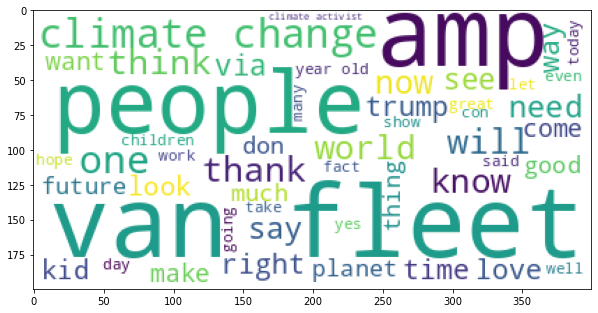

In [28]:
## Creating word cloud image
plt.figure(figsize=(10,10))
plt.imshow(wc)

In [29]:
## Calling VADER function for sentimental analysis
analyser = SentimentIntensityAnalyzer()

In [30]:
# Creating function to extract compound sentiment from tweets
def polarity(text):
    text = analyser.polarity_scores(text)['compound']
    return text

In [31]:
# Using sentiment function over UDF
polarityUDF = udf(lambda x:polarity(x),FloatType())

In [32]:
# Applying UDF on tweet text column and storing result in new polarity column
df_work = df_work.withColumn('polarity', polarityUDF(F.col('Text')))

In [33]:
# Inspecting result of sentiment
df_work.show(5)

+-----+--------------------+-------------------+--------+
|rowId|                Text|          Timestamp|polarity|
+-----+--------------------+-------------------+--------+
|   10|mahal man tlga cl...|2018-06-09 12:14:59|  0.5574|
|   20|get out mind mind...|2018-06-09 12:32:20|     0.0|
|   30|get ready hope do...|2018-06-09 12:39:53|  0.6597|
|   40|                 omg|2018-06-09 12:45:16|     0.0|
|   50|was always most a...|2018-06-09 12:57:04|  0.7996|
+-----+--------------------+-------------------+--------+
only showing top 5 rows



In [34]:
# Converting dataframe to pandas for extensive analysis
df_pd = df_work.toPandas()

In [35]:
# Checking number of rows to confirm dataset conversion passed
df_pd.count()

rowId        480941
Text         480941
Timestamp    480941
polarity     480941
dtype: int64

In [36]:
# Checking info for column names and types
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480941 entries, 0 to 480940
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   rowId      480941 non-null  int64  
 1   Text       480941 non-null  object 
 2   Timestamp  480941 non-null  object 
 3   polarity   480941 non-null  float32
dtypes: float32(1), int64(1), object(2)
memory usage: 12.8+ MB


In [37]:
# Checking empty rows with empty text just in case
df_pd['Text'].isna().sum()

0

In [38]:
# Rearranging columns
df_pd = df_pd.reindex(columns=['rowId', 'Timestamp', 'Text', 'polarity'])

In [39]:
# Checking dataset for column names
df_pd.head(20)

,rowId,Timestamp,Text,polarity
0,10,2018-06-09 12:14:59,mahal man tlga claui baya ako hahaha,0.5574
1,20,2018-06-09 12:32:20,get out mind minds think alike,0.0000
2,30,2018-06-09 12:39:53,get ready hope does not mean the summit singap...,0.6597
3,40,2018-06-09 12:45:16,omg,0.0000
4,50,2018-06-09 12:57:04,was always most admired and respected and sour...,0.7996
5,60,2018-06-09 13:02:49,tim horton come,0.0000
6,70,2018-06-09 13:14:34,igaz nem lehet tenni ezzel szeg medv vel most ...,0.0000
7,80,2018-06-09 13:23:08,van fleet black smoke rising via,0.0000
8,90,2018-06-09 13:31:21,piece art work savelucifer pickuplucifer,0.0000
9,100,2018-06-09 13:38:04,loooong trip can not mention jetlag you will i...,0.9260


In [40]:
# checking number of neutral sentiment rows
df_pd.query('polarity == 0.0000').count()

rowId        212162
Timestamp    212162
Text         212162
polarity     212162
dtype: int64

Final dataset will have one row per day. Current dataset has more than one tweet per day. To reduce dataset, we will take average of sentiment in one day. Before this calculation neutral sentiment rows will be dropped.

In [41]:
# Inspecting unique timestamps
df_pd['Timestamp'].unique()

array(['2018-06-09 12:14:59', '2018-06-09 12:32:20',
       '2018-06-09 12:39:53', ..., '2019-10-19 10:44:48',
       '2019-10-19 10:45:21', '2019-10-19 10:45:55'], dtype=object)

In [42]:
# Slicing timestamp for only YYYY-MM-DD because we only need days
df_pd['Timestamp'] = df_pd['Timestamp'].str.slice(stop=10)

In [43]:
# Inspecting dataset
df_pd

,rowId,Timestamp,Text,polarity
0,10,2018-06-09,mahal man tlga claui baya ako hahaha,0.5574
1,20,2018-06-09,get out mind minds think alike,0.0000
2,30,2018-06-09,get ready hope does not mean the summit singap...,0.6597
3,40,2018-06-09,omg,0.0000
4,50,2018-06-09,was always most admired and respected and sour...,0.7996
...,...,...,...,...
480936,4809370,2019-10-19,ker att det inte george soros och rjev nner,0.0000
480937,4809380,2019-10-19,yes agree,0.6369
480938,4809390,2019-10-19,have never seen such blaming yes from both rep...,0.6517
480939,4809400,2019-10-19,feel miffed that jason blocked but also refuse...,-0.2144


In [44]:
# Creating new df that will be used for modeling and predictions
df_model = pd.DataFrame(columns=['Timestamp','polarity'])

In [45]:
# Creating function for aggregating non neutral sentiment rows and
# dividing by number of rows to get average compound sentiment per day
a=0
b=0
c=0
for i in df_pd['Timestamp'].unique():
    a = df_pd['polarity'][(df_pd['polarity'] != 0.0000) &
                          (df_pd['Timestamp'] == i)].sum()
    b = len(df_pd[(df_pd['polarity'] != 0.0000) &
                  (df_pd['Timestamp'] == i)])
    c=a/b
    new_row = pd.DataFrame({'Timestamp':i,'polarity':c},index=[0])
    df_model = pd.concat([new_row,df_model.loc[:]]).reset_index(drop=True)

In [46]:
# Resetting index of dataset
df_model = df_model[::-1].reset_index(drop=True)

In [47]:
# Inspecting dataset
df_model

,Timestamp,polarity
0,2018-06-09,0.287891
1,2018-06-10,0.276062
2,2018-06-11,0.361704
3,2018-06-12,0.168519
4,2018-06-13,0.241579
...,...,...
493,2019-10-15,0.001565
494,2019-10-16,0.061888
495,2019-10-17,0.084444
496,2019-10-18,0.077118


In [48]:
# Converting timestamp from string to pandas datetime type
df_model['Timestamp'] = pd.to_datetime(df_model['Timestamp'],format='%Y/%m/%d')

In [49]:
# Moving timestamp to index of df
df_model = df_model.set_index('Timestamp')

In [50]:
# Removing name of the index column
df_model.index.name = None

In [51]:
# Inspecting dataset
df_model

,polarity
2018-06-09,0.287891
2018-06-10,0.276062
2018-06-11,0.361704
2018-06-12,0.168519
2018-06-13,0.241579
...,...
2019-10-15,0.001565
2019-10-16,0.061888
2019-10-17,0.084444
2019-10-18,0.077118


In [52]:
# Sentiment is originally [-1,1]. For modeling scaling the data to [0,1]
scaler = MinMaxScaler()
scaled_data = scaler.fit(df_model)
df_model['polarity'] = scaler.transform(df_model)

In [53]:
# Inspecting
df_model

,polarity
2018-06-09,0.849037
2018-06-10,0.824843
2018-06-11,1.000000
2018-06-12,0.604897
2018-06-13,0.754318
...,...
2019-10-15,0.263441
2019-10-16,0.386814
2019-10-17,0.432946
2019-10-18,0.417963


In [58]:
# Moving data to csv for backup
df_model.to_csv("/home/hduser/gretaFinal.csv")

In [59]:
# Counting positive and negative sentiment
df_pd.query('polarity > 0.5').count()

rowId        75030
Timestamp    75030
Text         75030
polarity     75030
dtype: int64

In [60]:
df_pd.query('polarity < 0.5').count()

rowId        405910
Timestamp    405910
Text         405910
polarity     405910
dtype: int64

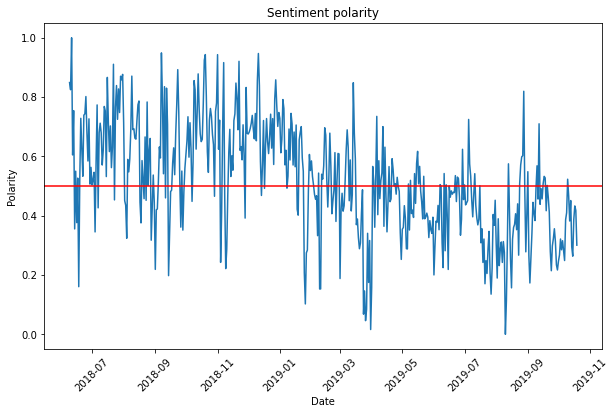

In [61]:
# Plotting sentiment data
plt.rc("figure",figsize=(10,6))
plt.ylabel('Polarity')
plt.xlabel('Date')
plt.title('Sentiment polarity')
plt.xticks(rotation=45)
plt.plot(df_model.index, df_model['polarity'], )
plt.axhline(y=0.5, color='r', linestyle='-')

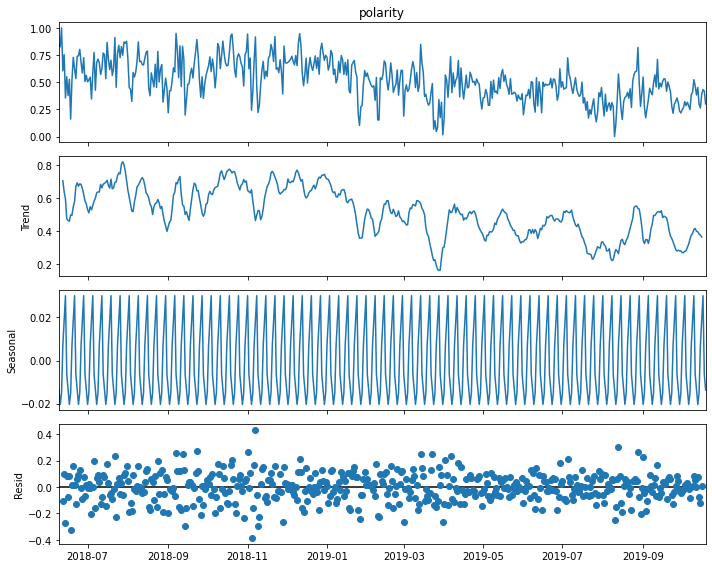

In [62]:
# Decomposing sentiment
result = seasonal_decompose(df_model['polarity'], model='additive')
plt.rc("figure",figsize=(10,8))
result.plot()
plt.show()

In [63]:
# Create rolling function for better understanding trend
def rolling(window=7):    
    #Creating rolling df
    df_roll = pd.DataFrame(columns=['rolling_avg',
                                    'rolling_std'])

    #Determine rolling statistics
    df_roll["rolling_avg"] = df_model["polarity"].rolling(window).mean()
    df_roll["rolling_std"] = df_model["polarity"].rolling(window).std()

    #Plot rolling statistics
    plt.figure(figsize=(20,10))
    plt.plot(df_model["polarity"], color='blue', label='Original')
    plt.plot(df_roll["rolling_avg"], color='red', label='Rolling Mean')
    plt.plot(df_roll["rolling_std"], color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Polarity Rolling Mean & Standard Deviation')
    plt.show(block=False)

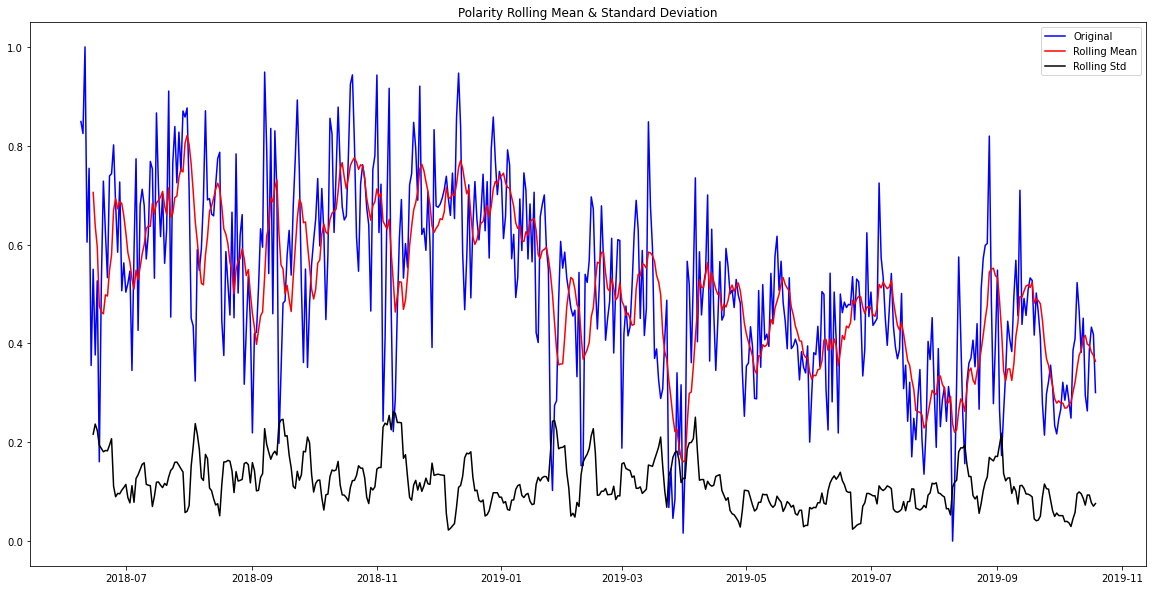

In [64]:
# Week of rolling
rolling(7)

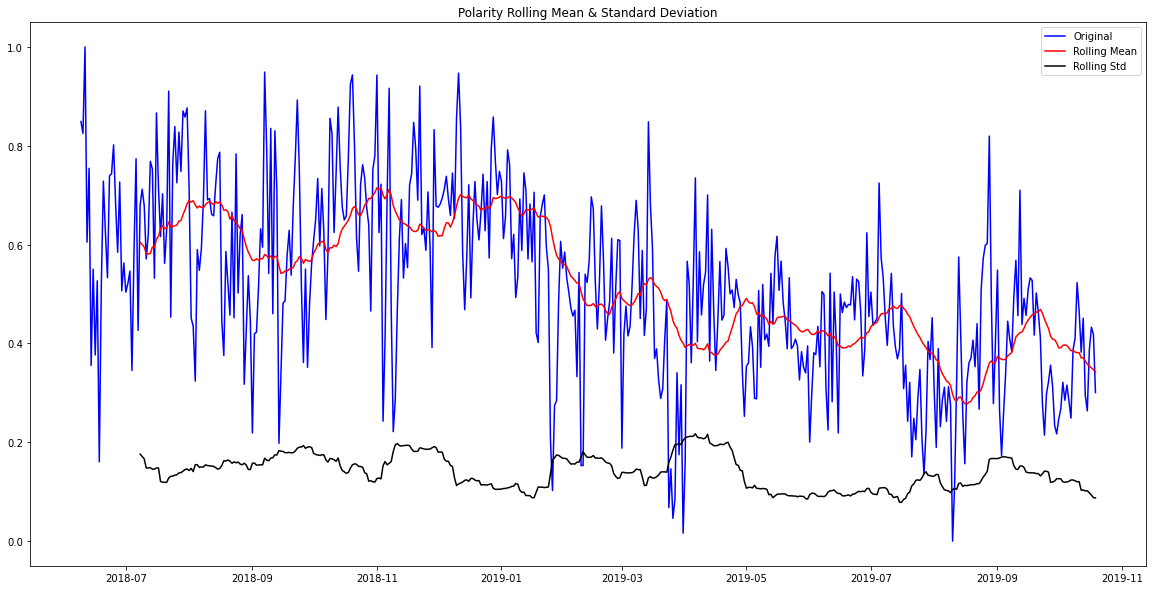

In [65]:
# Month of rolling
rolling(30)

The ADF test produces a test statistic that measures the strength of evidence against the null hypothesis of non-stationarity. The test statistic is compared against critical values to determine whether the null hypothesis can be rejected or not. If the test statistic is lower than the critical values, it suggests that the time series is stationary and does not require differencing. Conversely, if the test statistic is higher than the critical values, it indicates that the series is non-stationary.

In [66]:
# Augmented Dickey-Fuller Test function
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series,autolag='AIC')
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [67]:
# Execute ADF test
adf_test(df_model['polarity'],title='Sentiment')

Augmented Dickey-Fuller Test: Sentiment
ADF test statistic       -2.095083
p-value                   0.246496
# lags used              18.000000
# observations          479.000000
critical value (1%)      -3.444076
critical value (5%)      -2.867593
critical value (10%)     -2.569994
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


It assesses the stationarity of a time series and provides complementary information to the Augmented Dickey-Fuller (ADF) test. While the ADF test focuses on determining non-stationarity, the KPSS test is used to test for stationarity.

In [68]:
# The Kwiatkowski-Phillips-Schmidt-Shin Test
result = kpss(df_model['polarity'])
print(result)
print('KPSS Test Statistics: %.2f' % result[0])
print('1%% Critical Value: %.2f' % result[3]['1%'])
print('5%% Critical Value: %.2f' % result[3]['5%'])
print('10%% Critical Value: %.2f' % result[3]['10%'])
print('p-value: %.2f' % result[1])
if result[1] >= 0.05:
    print("Strong evidence against the null hypothesis")
    print("Reject the null hypothesis")
    print("Data has no unit root and is stationary")
else:
    print("Weak evidence against the null hypothesis")
    print("Fail to reject the null hypothesis")
    print("Data has a unit root and is non-stationary")

(2.716269845259983, 0.01, 11, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistics: 2.72
1% Critical Value: 0.74
5% Critical Value: 0.46
10% Critical Value: 0.35
p-value: 0.01
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


/tmp/ipykernel_26390/3021799082.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df_model['polarity'])


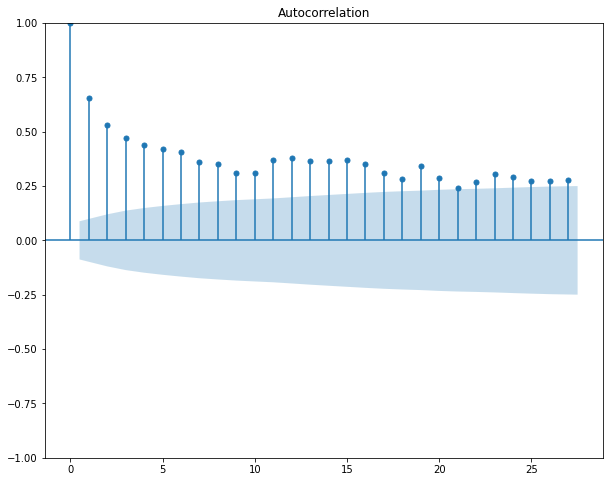

In [69]:
# ACF plot
plot_acf(df_model['polarity'])
plt.show()

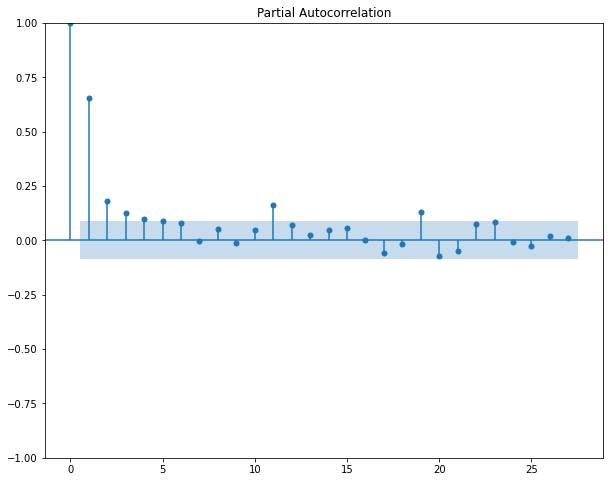

In [70]:
# PACF plot
plot_pacf(df_model['polarity'])
plt.show()

# Modeling and prediction

For modeling and prediction SARIMA model is used.

In [25]:
# Moving data to csv for backup
#df_model = pd.DataFrame(columns=['Timestamp','polarity'])
df_model = pd.read_csv("/home/hduser/gretaFinal.csv")
df_model['Unnamed: 0'] = pd.to_datetime(df_model['Unnamed: 0'],format='%Y/%m/%d')
df_model = df_model.set_index('Unnamed: 0')
df_model.index.name = None

In [26]:
df_model

,polarity
2018-06-09,0.849037
2018-06-10,0.824843
2018-06-11,1.000000
2018-06-12,0.604897
2018-06-13,0.754318
...,...
2019-10-15,0.263441
2019-10-16,0.386814
2019-10-17,0.432946
2019-10-18,0.417963


In [39]:
# Split data into train-test - 
# ==============================================================================
steps = 90
data_train = df_model[:-steps]
data_test = df_model[-steps:]

In [74]:
# Create array to save results
AIC = [[],[],[]]

#Create function to cycle through different frequencies
for i in range(1,15):
    SARIMA_model = pm.auto_arima(data_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, max_d=2,
                             m=i, 
                             start_P=0, 
                             seasonal=True,
                             d=1, D=1,
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)
    AIC[0].append(SARIMA_model.aic())
    AIC[1].append(SARIMA_model)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-444.486, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-330.457, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-379.219, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-416.604, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-332.413, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-445.703, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-398.532, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-444.711, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-441.405, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-446.479, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-432.282, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-439.559, Time=0.84 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-438.004, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-441.628, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0]          

 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-88.693, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-216.024, Time=0.30 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.99 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-173.842, Time=0.17 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-243.879, Time=0.37 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-219.561, Time=0.18 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.19 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.42 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=-252.953, Time=0.41 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=-230.247, Time=0.27 sec
 ARIMA(3,1,0)(2,1,1)[7]             : AIC=inf, Time=3.18 sec
 ARIMA(3,1,0)(1,1,1)[7]             : AIC=inf, Time=1.05 sec
 ARIMA(3,1,1)(2,1,0)[7]             : AIC=inf, Time=2.33 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=inf, Time

 ARIMA(1,1,1)(0,1,1)[13]             : AIC=inf, Time=1.93 sec
 ARIMA(0,1,0)(0,1,0)[13]             : AIC=-41.455, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[13]             : AIC=-187.905, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[13]             : AIC=inf, Time=1.54 sec
 ARIMA(1,1,0)(0,1,0)[13]             : AIC=-88.067, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[13]             : AIC=-238.528, Time=0.94 sec
 ARIMA(1,1,0)(2,1,1)[13]             : AIC=inf, Time=4.85 sec
 ARIMA(1,1,0)(1,1,1)[13]             : AIC=inf, Time=2.02 sec
 ARIMA(0,1,0)(2,1,0)[13]             : AIC=-195.651, Time=0.41 sec
 ARIMA(2,1,0)(2,1,0)[13]             : AIC=-260.217, Time=0.88 sec
 ARIMA(2,1,0)(1,1,0)[13]             : AIC=-210.709, Time=0.50 sec
 ARIMA(2,1,0)(2,1,1)[13]             : AIC=inf, Time=6.58 sec
 ARIMA(2,1,0)(1,1,1)[13]             : AIC=inf, Time=2.61 sec
 ARIMA(3,1,0)(2,1,0)[13]             : AIC=-267.929, Time=1.71 sec
 ARIMA(3,1,0)(1,1,0)[13]             : AIC=-223.226, Time=0.42 sec
 ARIMA(3,1,0)(2,1,1)[13]   

In [80]:
# AIC results
AIC[0]

[-446.4830786179223,
 -279.21840452160575,
 -259.5872226052263,
 -294.5229873613521,
 -267.67956911337,
 -281.515803544719,
 -252.95330831599676,
 -283.3310695666981,
 -256.94233391014194,
 -253.03427853462892,
 -276.01205291062513,
 -268.3962164137124,
 -267.92907457101626,
 -280.1285189332491]

In [98]:
#top results
print('Top result - AIC:',AIC[0][0], AIC[1][0])
print('Second best - AIC',AIC[0][3], AIC[1][3])
print('Third best - AIC',AIC[0][7], AIC[1][7])

Top result - AIC: -446.4830786179223  ARIMA(1,1,2)(0,0,0)[0]          
Second best - AIC -294.5229873613521  ARIMA(3,1,0)(2,1,0)[4]          
Third best - AIC -283.3310695666981  ARIMA(3,1,0)(2,1,0)[8]          


In [87]:
# Function to predict and plot data
def sarimaFunction(model,step):
    step_test = data_test[:step]
    future_forcast = model.predict(n_periods=step)
    fig, ax=plt.subplots(figsize=(9, 4))
    step_test.plot(ax=ax, label='test')
    future_forcast.plot(ax=ax, label='prediction')
    print('Mean squared error: {0:0.4f}'.format(mean_squared_error(step_test,future_forcast)))
    ax.legend();

Mean squared error: 0.0243


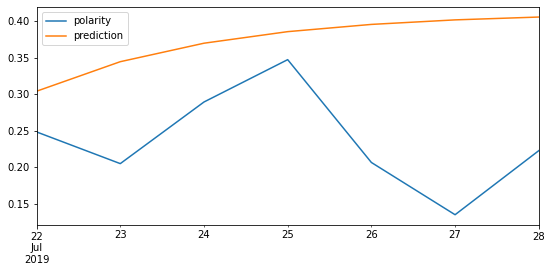

In [88]:
# Predicting with top model and 7 day forecast
sarimaFunction(AIC[1][0],7)

Mean squared error: 0.0248


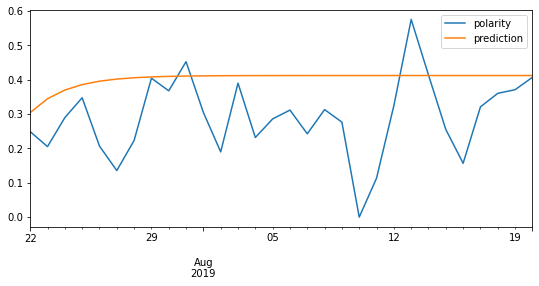

In [89]:
# Predicting with top model and 30 day forecast
sarimaFunction(AIC[1][0],30)

Mean squared error: 0.0192


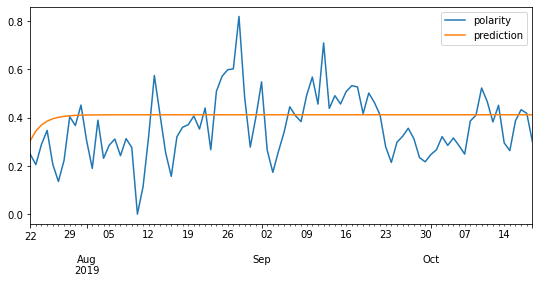

In [90]:
# Predicting with top model and 90 day forecast
sarimaFunction(AIC[1][0],90)

Mean squared error: 0.0086


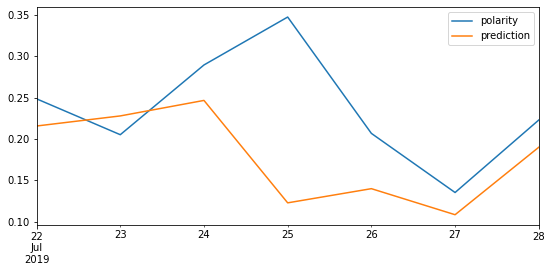

In [91]:
# Predicting with second model and 7 day forecast
sarimaFunction(AIC[1][3],7)

Mean squared error: 0.1961


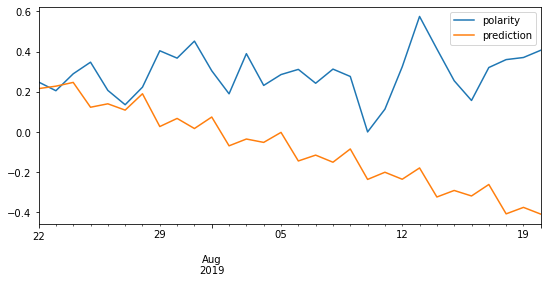

In [92]:
# Predicting with second model and 30 day forecast
sarimaFunction(AIC[1][3],30)

Mean squared error: 1.5683


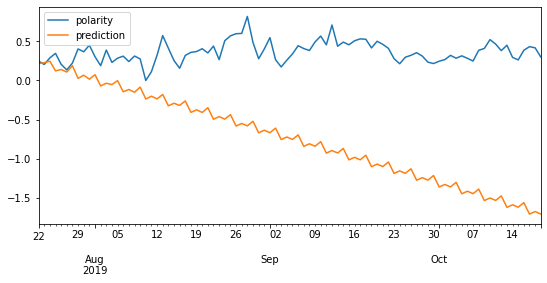

In [93]:
# Predicting with second model and 90 day forecast
sarimaFunction(AIC[1][3],90)

Mean squared error: 0.0090


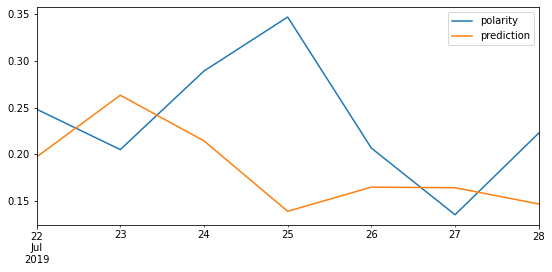

In [95]:
# Predicting with third model and 7 day forecast
sarimaFunction(AIC[1][7],7)

Mean squared error: 0.1126


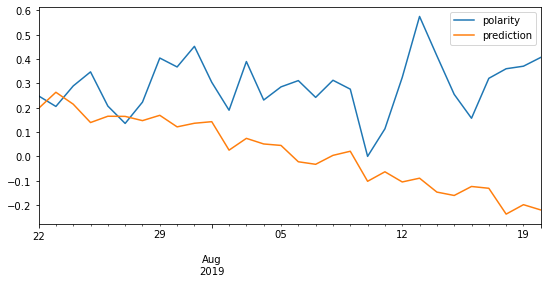

In [96]:
# Predicting with third model and 30 day forecast
sarimaFunction(AIC[1][7],30)

Mean squared error: 0.9060


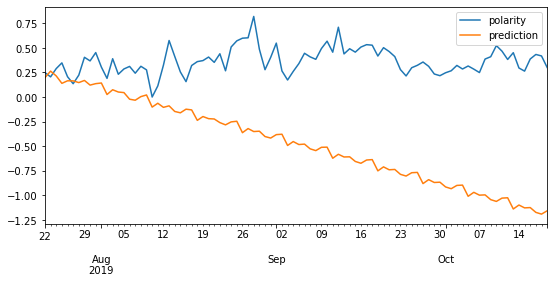

In [97]:
# Predicting with third model and 90 day forecast
sarimaFunction(AIC[1][7],90)